### Import Libraries and Set Initial Configurations

In [1]:
import os
import re
import torch
import numpy as np
import pandas as pd
import torchvision.models as models
import torch.nn as nn
from pylab import cm
from PIL import Image, ImageOps
from skimage.io import imread
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
import torch.optim as optim
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, ConfusionMatrixDisplay, accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from torch.optim.lr_scheduler import StepLR
from torchvision.utils import make_grid

### Setting initial configurations

In [2]:
sns.set_theme()
print(os.cpu_count())
torch.set_num_threads(os.cpu_count())

4


### Load the data and visualize for a random image

In [ ]:
sample_img_path = 'Dataset1/Leptocylindrus_mediterraneus/IFCB5_2014_259_122510_01477.png'
dataset_path = '/Dataset1'
im = imread(sample_img_path, as_gray=True)
plt.imshow(im, cmap=cm.gray)
plt.show()

### Utility functions

In [4]:
class HistogramEqualization:
    def __call__(self, img):
        return ImageOps.equalize(img)


def plot_images(images, labels, rows=None, cols=None):
    """
    Plots a list of images with their labels in a grid.
    
    :param images: List of images (as NumPy arrays).
    :param labels: List of labels.
    :param rows: Number of rows in the subplot grid.
    :param cols: Number of columns in the subplot grid.
    """
    # Determine the number of images
    num_images = len(images)
    
    # Determine the grid size if not specified
    if not rows or not cols:
        if num_images == 1:
            rows, cols = 1, 1
        else:
            rows = int(np.sqrt(num_images))
            cols = int(np.ceil(num_images / rows))
    
    # Create figure with subplots
    fig, axs = plt.subplots(rows, cols, figsize=(3 * cols, 3 * rows))
    axs = np.array(axs)
    
    for idx, (img, label) in enumerate(zip(images, labels)):
        ax = axs.flatten()[idx]
        ax.imshow(img)
        ax.set_title(f'Label: {label}')
        ax.axis('off')  # Hide axes ticks
    
    # Hide any unused subplots
    if num_images < rows * cols:
        for ax in axs.flatten()[num_images:]:
            ax.axis('off')
    
    plt.tight_layout()
    plt.show()


def is_image_file(filename):
    """
    Filter images of particular format.
    
    :param filename: Image filename.
    """
    valid_extensions = ['.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif', '.tiff', '.webp']
    return any(filename.lower().endswith(ext) for ext in valid_extensions)


def plot_confusion_matrix(cm, classes):
    """
    This function prints and plots the confusion matrix.
    """
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1.2)
    sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Blues, cbar=False,
                xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.show()
    
    
def format_name(name):
    formatted_name = re.sub(r'_', ' ', name)
    formatted_name = formatted_name.capitalize()
    return formatted_name


def calculate_mean_std(loader):
    mean = 0.
    std = 0.
    total_images_count = 0
    for images, _ in loader:
        batch_samples = images.size(0)
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_images_count += batch_samples

    mean /= total_images_count
    std /= total_images_count

    return mean, std


## Data augmentation and preprocessing

In [5]:
# Data augmentation and preprocessing
width, height = 224, 224  # VGG16 accepted model dimensions
transform = transforms.Compose([
    transforms.Resize((width, height)),
    transforms.ToTensor(),
])

### Load the dataset

In [6]:
dataset = datasets.ImageFolder(root=dataset_path, transform=transform, is_valid_file=is_image_file)
print(dataset)

Dataset ImageFolder
    Number of datapoints: 3739
    Root location: /kaggle/input/dataset1/Dataset1
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
           )


### Visualize the class distribution

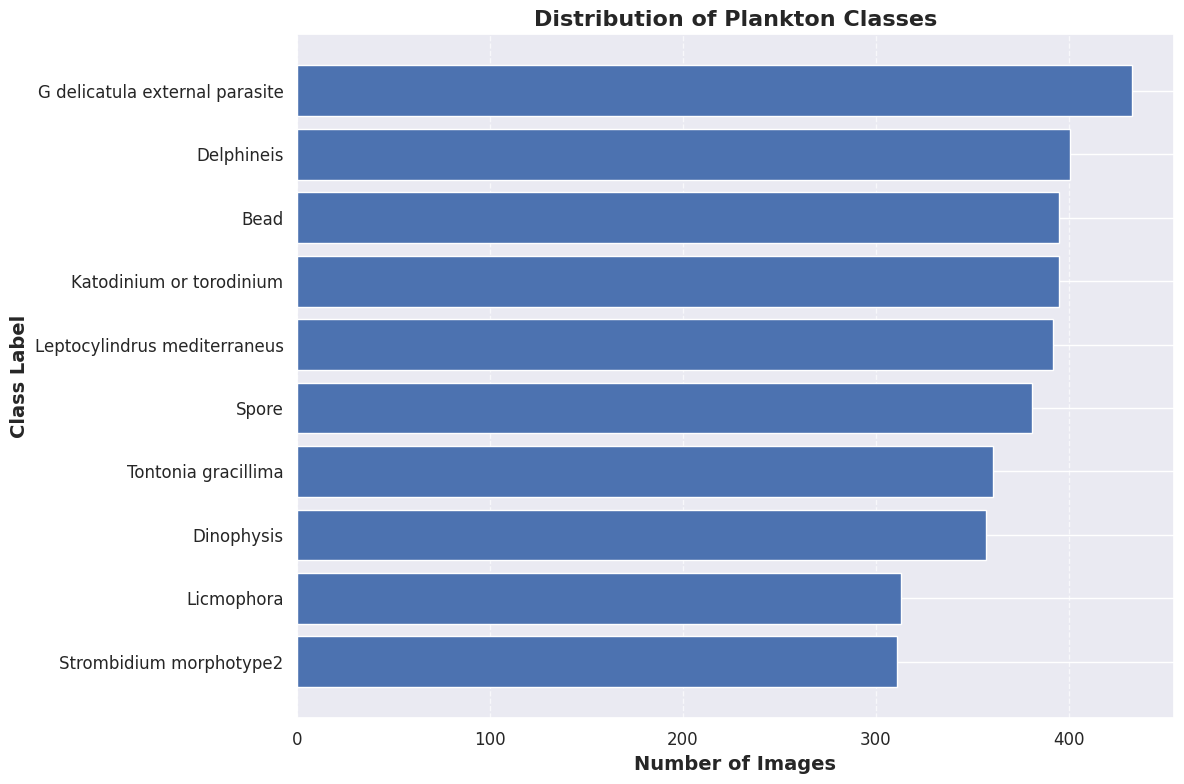

In [7]:
class_counts = Counter([dataset.classes[i] for _, i in dataset])

original_classes = dataset.classes 

classes = list(class_counts.keys())
counts = list(class_counts.values())

classes = [format_name(label) for label in classes]


sorted_indices = sorted(range(len(counts)), key=lambda k: counts[k])
classes_sorted = [classes[i] for i in sorted_indices]
counts_sorted = [counts[i] for i in sorted_indices]

plt.figure(figsize=(12, 8)) 
plt.barh(classes_sorted, counts_sorted)
plt.xlabel('Number of Images', fontsize=14, fontweight='bold') 
plt.ylabel('Class Label', fontsize=14, fontweight='bold')
plt.title('Distribution of Plankton Classes', fontsize=16, fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12, rotation=0) 
plt.grid(axis='x', linestyle='--', alpha=0.7) 
plt.tight_layout() 
plt.show()

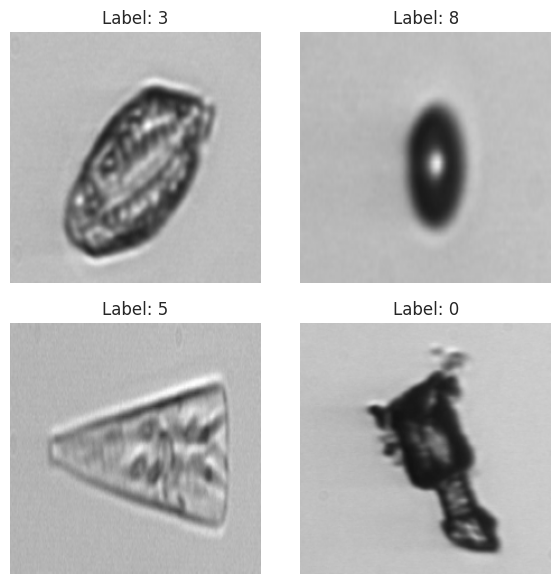

In [8]:
indices = [1230, 3130, 2130, 12]
images = []
labels = []

for idx in indices:
    img, lbl = dataset[idx] 
    img = img.numpy().transpose((1, 2, 0))  # Transpose the image dimensions
    # Optional: Unnormalize if your dataset includes normalization
    # img = img * std + mean
    # img = np.clip(img, 0, 1)
    images.append(img)
    labels.append(lbl)

plot_images(images, labels)

## Training and Validation

### Set the seed for reproducibility and split the data 

In [9]:
SEED = 42
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

train_size = int(0.8 * len(dataset))
validate_size = len(dataset) - train_size
train_data, test_data = random_split(dataset, [train_size, validate_size])

### Creating Dataloaders

In [10]:
batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)
validate_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=4)

### Visualize first batch of data

In [ ]:
%%time 

sample_image = iter(train_loader)

first_batch_samples,first_batch_labels = next(sample_image)
print(first_batch_samples.shape) #64 batch size, 1 channel, width 224 , height 224
print(first_batch_labels)

# Check the shape of the entire batch
print('Batch shape:', first_batch_samples.shape)

# Create a grid of images
grid = make_grid(first_batch_samples, nrow=16)  # Adjust 'nrow' to how many images you want per row

# Permute and normalize the grid for display
grid = grid.permute(1, 2, 0)  # Change from [C, H, W] to [H, W, C]
plt.figure(figsize=(16,8))
plt.axis('off')
plt.imshow(grid.numpy())
plt.show()

torch.Size([64, 3, 224, 224])
tensor([2, 9, 3, 6, 9, 2, 8, 5, 8, 1, 4, 9, 2, 1, 2, 0, 1, 9, 3, 5, 0, 8, 9, 2,
        5, 3, 9, 6, 4, 4, 1, 9, 7, 5, 9, 1, 4, 9, 8, 8, 8, 0, 6, 4, 0, 0, 1, 2,
        2, 8, 1, 0, 2, 4, 1, 8, 5, 1, 2, 3, 8, 9, 8, 0])
Batch shape: torch.Size([64, 3, 224, 224])


### Visualize secound batch of data

In [ ]:
%%time 

second_batch_samples,second_batch_labels = next(sample_image)
print(second_batch_samples.shape) #64 batch size, 1 channel, width 224 , height 224
print(second_batch_labels)

# Check the shape of the entire batch
print('Batch shape:', second_batch_samples.shape)

# Create a grid of images
grid = make_grid(second_batch_samples, nrow=16)  # Adjust 'nrow' to how many images you want per row

# Permute and normalize the grid for display
grid = grid.permute(1, 2, 0)  # Change from [C, H, W] to [H, W, C]
plt.figure(figsize=(16,8))
plt.axis('off')
plt.imshow(grid.numpy())
plt.show()

torch.Size([64, 3, 224, 224])
tensor([9, 4, 0, 0, 3, 0, 4, 7, 8, 0, 6, 1, 7, 7, 6, 8, 0, 6, 3, 2, 9, 8, 3, 0,
        3, 6, 0, 5, 0, 6, 3, 6, 2, 4, 2, 7, 4, 9, 7, 0, 1, 4, 4, 1, 2, 9, 0, 0,
        0, 2, 5, 6, 5, 0, 9, 7, 7, 9, 6, 1, 2, 6, 8, 0])
Batch shape: torch.Size([64, 3, 224, 224])


## Model Preparation

In [13]:
# Loading the pre-defined architecture
model = models.vgg16(pretrained=False) 

# Loading the custom model weights
model = torch.load('cnn-pretrained/phytoplankton-cnn.ph')

# we are setting the model to evaluation mode
model.eval()

# Modifying the classifier part of the VGG16
num_features = model.classifier[6].in_features  # Get the input feature count of the last layer
new_classifier = nn.Sequential(
    *list(model.classifier.children())[:-1],  # Keep all layers except the last one
    nn.Linear(num_features, 512),  # Add a new second last layer
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(512, 10)  # Final layer for 10 classes
)
model.classifier = new_classifier

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


### Define loss function and optimizer

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=1e-4)

### Training the model

In [15]:
# Initialize lists to track the metrics
train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []

num_epochs = 50
print(f"{'Epoch':^5} | {'Train Loss':^12} | {'Train Acc':^10} | {'Val Loss':^10} | {'Val Acc':^8} | {'Correct':^8} | {'Total':^6}")
print('-' * 70)

for epoch in range(num_epochs):
    model.train()
    train_loss, correct_train, total_train = 0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    avg_train_loss = train_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    model.eval()
    val_loss, correct_val, total_val = 0, 0, 0

    with torch.no_grad():
        for images, labels in validate_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    avg_val_loss = val_loss / len(validate_loader)
    val_accuracy = 100 * correct_val / total_val
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    print(f"{epoch + 1:^5} | {avg_train_loss:^12.4f} | {train_accuracy:^10.2f} | {avg_val_loss:^10.4f} | {val_accuracy:^8.2f} | {correct_val:^8} | {total_val:^6}")

Epoch |  Train Loss  | Train Acc  |  Val Loss  | Val Acc  | Correct  | Total 
----------------------------------------------------------------------
  1   |    1.6886    |   54.63    |   1.0427   |  82.62   |   618    |  748  
  2   |    0.8899    |   77.73    |   0.6474   |  85.16   |   637    |  748  
  3   |    0.6583    |   81.81    |   0.5160   |  86.63   |   648    |  748  
  4   |    0.5567    |   83.92    |   0.4535   |  88.50   |   662    |  748  
  5   |    0.5144    |   84.39    |   0.4101   |  88.37   |   661    |  748  
  6   |    0.4707    |   85.69    |   0.3860   |  89.57   |   670    |  748  
  7   |    0.4263    |   85.96    |   0.3622   |  90.24   |   675    |  748  
  8   |    0.4099    |   87.30    |   0.3387   |  90.91   |   680    |  748  
  9   |    0.4064    |   87.23    |   0.3307   |  90.24   |   675    |  748  
 10   |    0.3761    |   88.33    |   0.3128   |  91.18   |   682    |  748  
 11   |    0.3752    |   88.37    |   0.3043   |  91.58   |   685    | 

## Evaluation and Visualization of Results

### Learning curve

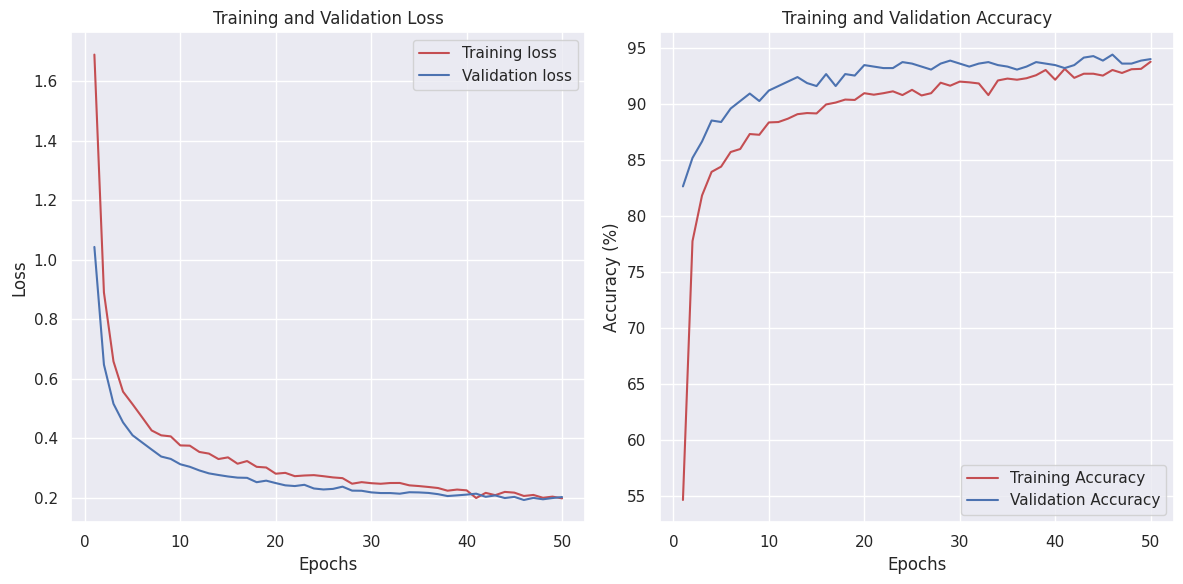

In [16]:
# Plot the learning curves
plt.figure(figsize=(12, 6))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, 'r-', label='Training loss')
plt.plot(range(1, num_epochs + 1), val_losses, 'b-', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, 'r-', label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, 'b-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

### Collecting information from the val_loader

In [17]:
true_labels = []
pred_labels = []
misclassified_images = []
misclassified_pred_labels = []
misclassified_true_labels = []

model.eval()
with torch.no_grad():
    for images, labels in validate_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())
        
        # Check for misclassifications
        misclassified_mask = preds != labels
        if any(misclassified_mask):
            misclassified_images.extend(images[misclassified_mask])
            misclassified_pred_labels.extend(preds[misclassified_mask])
            misclassified_true_labels.extend(labels[misclassified_mask])

# Calculate metrics
accuracy = accuracy_score(true_labels, pred_labels)
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, pred_labels, average='weighted')

### Total number of misclassified images

In [18]:
print(f"Total misclassified images: {len(misclassified_images)}")

Total misclassified images: 45


### Confusion matrix for the validation data

In [ ]:
class_names = dataset.classes

# Map numerical labels to actual class names
true_label_names = [class_names[label] for label in true_labels]
pred_label_names = [class_names[label] for label in pred_labels]

cm = confusion_matrix(true_label_names, pred_label_names, labels=class_names)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.title('Validation Data Confusion Matrix')
plt.ylabel('Actual labels')
plt.xlabel('Predicted labels')
plt.xticks(rotation=90)
plt.show()

### Confusion matrix for the train data

In [ ]:
train_true_labels = []
train_pred_labels = []


model.eval()
with torch.no_grad():
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        train_true_labels.extend(labels.cpu().numpy())
        train_pred_labels.extend(preds.cpu().numpy())

train_true_label_names = [class_names[label] for label in train_true_labels]
train_pred_label_names = [class_names[label] for label in train_pred_labels]


train_cm = confusion_matrix(train_true_label_names, train_pred_label_names, labels=class_names)

plt.figure(figsize=(12, 12))
sns.heatmap(train_cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.title('Training Data Confusion Matrix')
plt.ylabel('Actual Classes')
plt.xlabel('Predicted Classes')
plt.xticks(rotation=90)
plt.show()


### Visulization of Heat Maps for the misclassified images

Image 0: Predicted Label = bead, True Label = Delphineis


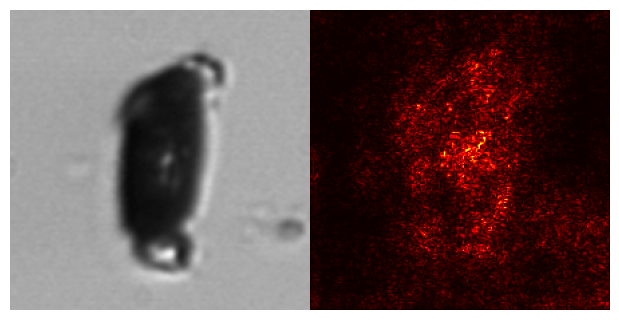

Image 1: Predicted Label = Licmophora, True Label = G_delicatula_external_parasite


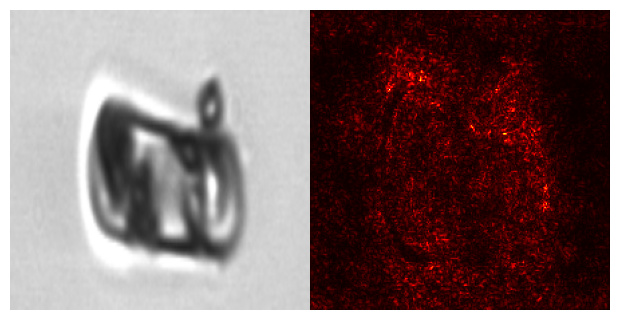

Image 2: Predicted Label = Tontonia_gracillima, True Label = Delphineis


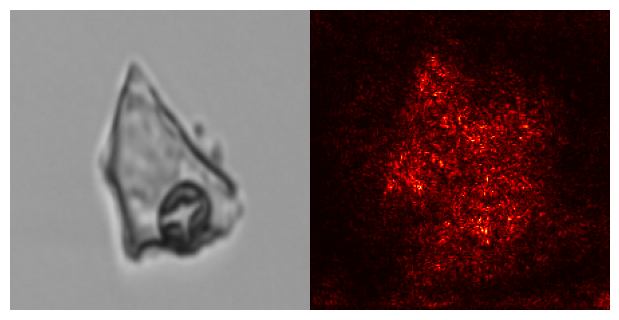

Image 3: Predicted Label = Dinophysis, True Label = Strombidium_morphotype2


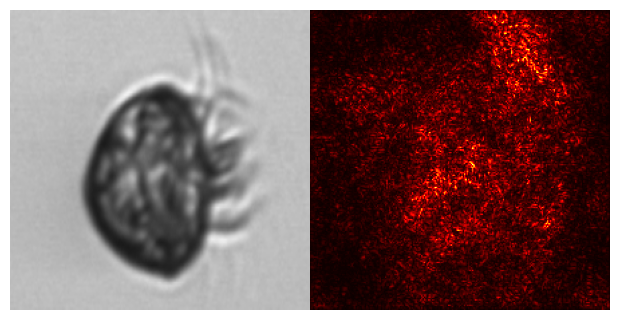

Image 4: Predicted Label = Dinophysis, True Label = Delphineis


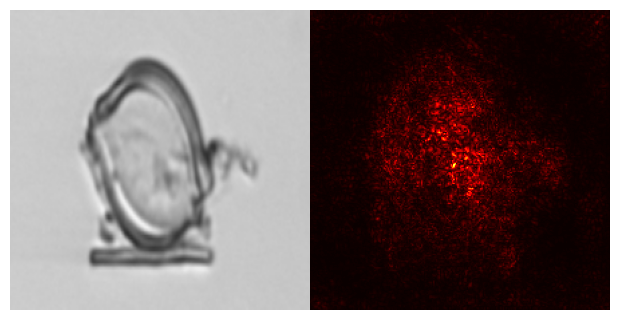

Image 5: Predicted Label = Leptocylindrus_mediterraneus, True Label = Delphineis


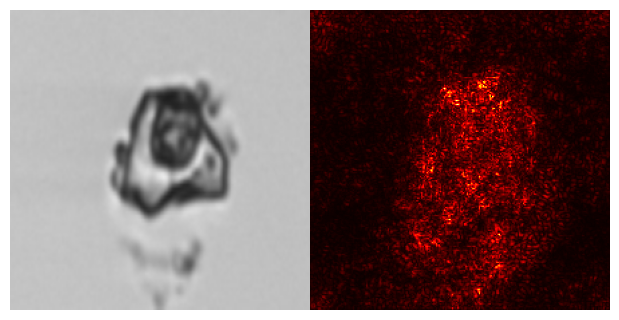

Image 6: Predicted Label = Katodinium_or_Torodinium, True Label = Strombidium_morphotype2


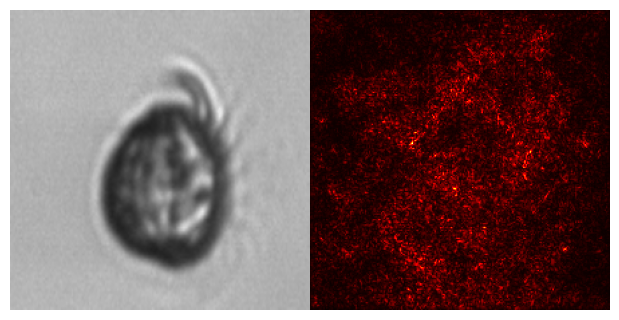

Image 7: Predicted Label = Tontonia_gracillima, True Label = spore


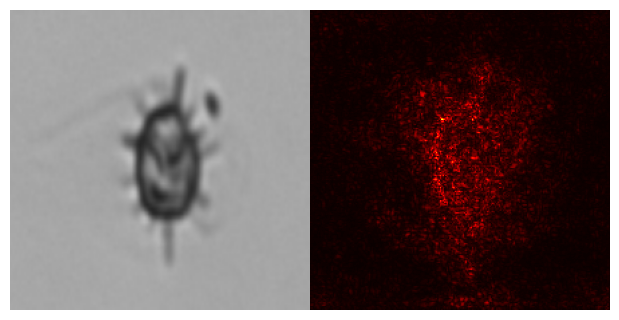

Image 8: Predicted Label = Leptocylindrus_mediterraneus, True Label = bead


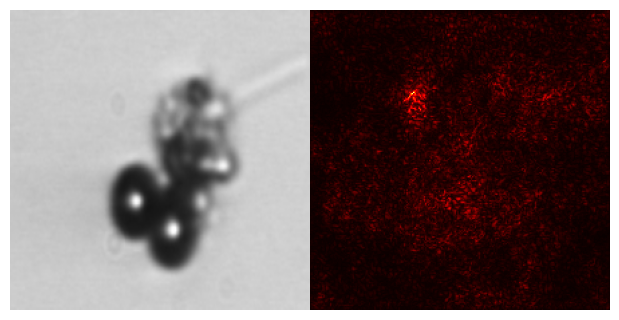

Image 9: Predicted Label = G_delicatula_external_parasite, True Label = spore


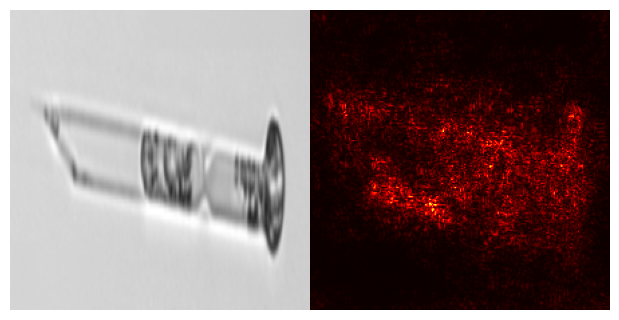

Image 10: Predicted Label = Tontonia_gracillima, True Label = spore


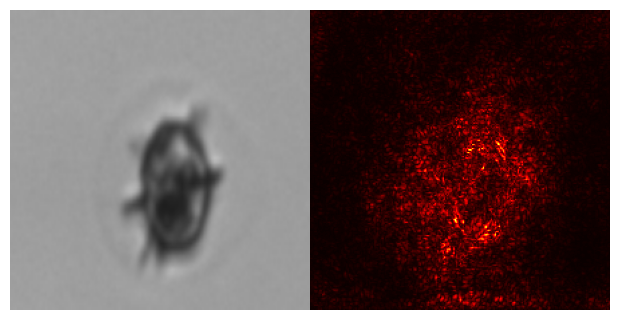

In [21]:
for i, (image, pred, true) in enumerate(zip(misclassified_images, misclassified_pred_labels, misclassified_true_labels)):
    if(i > 10):
        break
        
    print(f"Image {i}: Predicted Label = {dataset.classes[pred]}, True Label = {dataset.classes[true]}")
    # Convert tensor image to numpy for displaying
    image_np = image.cpu().numpy().transpose((1, 2, 0))
    
    image.requires_grad = True
    model.eval()
    outputs = model(image.unsqueeze(0))
    _, index = torch.max(outputs, 1)
    model.zero_grad()
    outputs[0, index].backward()
    saliency, _ = torch.max(image.grad.data.abs(), dim=0)
      
    fig = plt.figure(figsize=(6, 6))
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.imshow(image_np)
    ax1.axis('off')

    ax2 = fig.add_subplot(1, 2, 2)
    ax2.imshow(saliency.cpu().numpy(), cmap='hot')
    ax2.axis('off')

    plt.tight_layout(pad=0)
    plt.grid(False)
    plt.show()

### Metrics for the individual classes

                                precision    recall  f1-score   support

                    Delphineis       1.00      0.92      0.96        74
                    Dinophysis       0.88      0.93      0.91        74
G_delicatula_external_parasite       0.94      0.94      0.94        82
      Katodinium_or_Torodinium       0.93      0.98      0.96        98
  Leptocylindrus_mediterraneus       0.94      1.00      0.97        82
                    Licmophora       0.88      0.95      0.91        73
       Strombidium_morphotype2       0.98      0.89      0.94        65
           Tontonia_gracillima       0.91      0.94      0.92        62
                          bead       0.99      0.99      0.99        73
                         spore       0.96      0.83      0.89        65

                      accuracy                           0.94       748
                     macro avg       0.94      0.94      0.94       748
                  weighted avg       0.94      0.94      0.94 

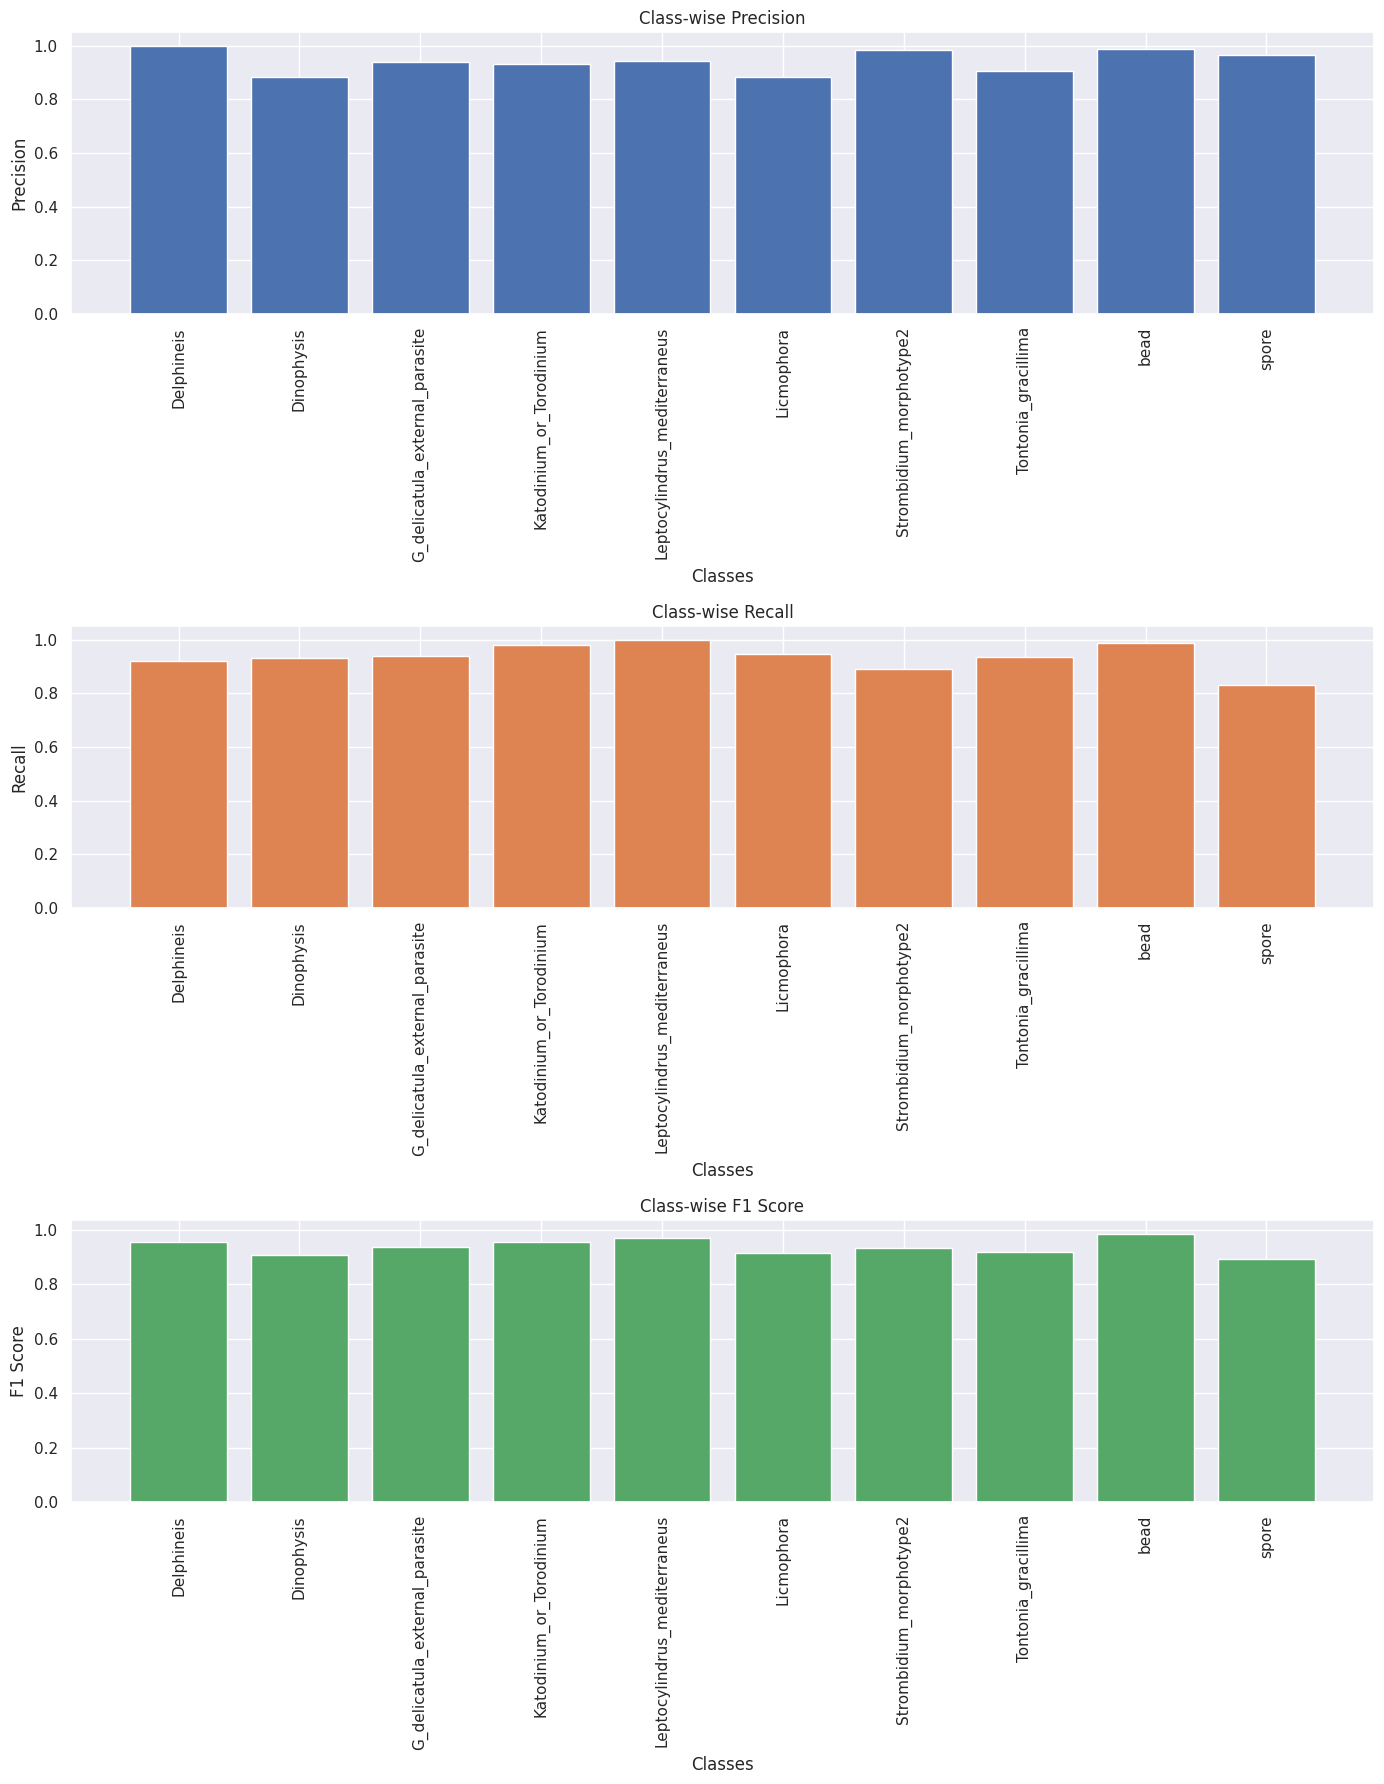

In [22]:
# Assume true_labels and pred_labels are lists of true and predicted labels from the validation set
true_labels = []
pred_labels = []

# Evaluate the model to get true_labels and pred_labels populated
model.eval()
with torch.no_grad():
    for images, labels in validate_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())

# Calculate class-specific metrics
precision, recall, f1, support = precision_recall_fscore_support(true_labels, pred_labels)

# Print the classification report using dataset.classes for the class names
print(classification_report(true_labels, pred_labels, target_names=dataset.classes))

# Bar plot for each metric
classes = dataset.classes
x = np.arange(len(classes))  # the label locations

fig, ax = plt.subplots(3, 1, figsize=(14, 18))

# Precision
ax[0].bar(x, precision, color='C0')
ax[0].set_title('Class-wise Precision')
ax[0].set_xlabel('Classes')
ax[0].set_ylabel('Precision')
ax[0].set_xticks(x)
ax[0].set_xticklabels(classes, rotation='vertical')

# Recall
ax[1].bar(x, recall, color='C1')
ax[1].set_title('Class-wise Recall')
ax[1].set_xlabel('Classes')
ax[1].set_ylabel('Recall')
ax[1].set_xticks(x)
ax[1].set_xticklabels(classes, rotation='vertical')

# F1 Score
ax[2].bar(x, f1, color='C2')
ax[2].set_title('Class-wise F1 Score')
ax[2].set_xlabel('Classes')
ax[2].set_ylabel('F1 Score')
ax[2].set_xticks(x)
ax[2].set_xticklabels(classes, rotation='vertical')

# Show plot
plt.tight_layout()
plt.show()

### Overall Accuracy of the model on test data

In [34]:
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {np.mean(precision):.2f}')
print(f'Recall: {np.mean(recall):.2f}')
print(f'F1 Score: {np.mean(f1):.2f}')

Accuracy: 0.94
Precision: 0.94
Recall: 0.94
F1 Score: 0.94


### Feature maps to understand how the model is trying to learn for a misclassified image

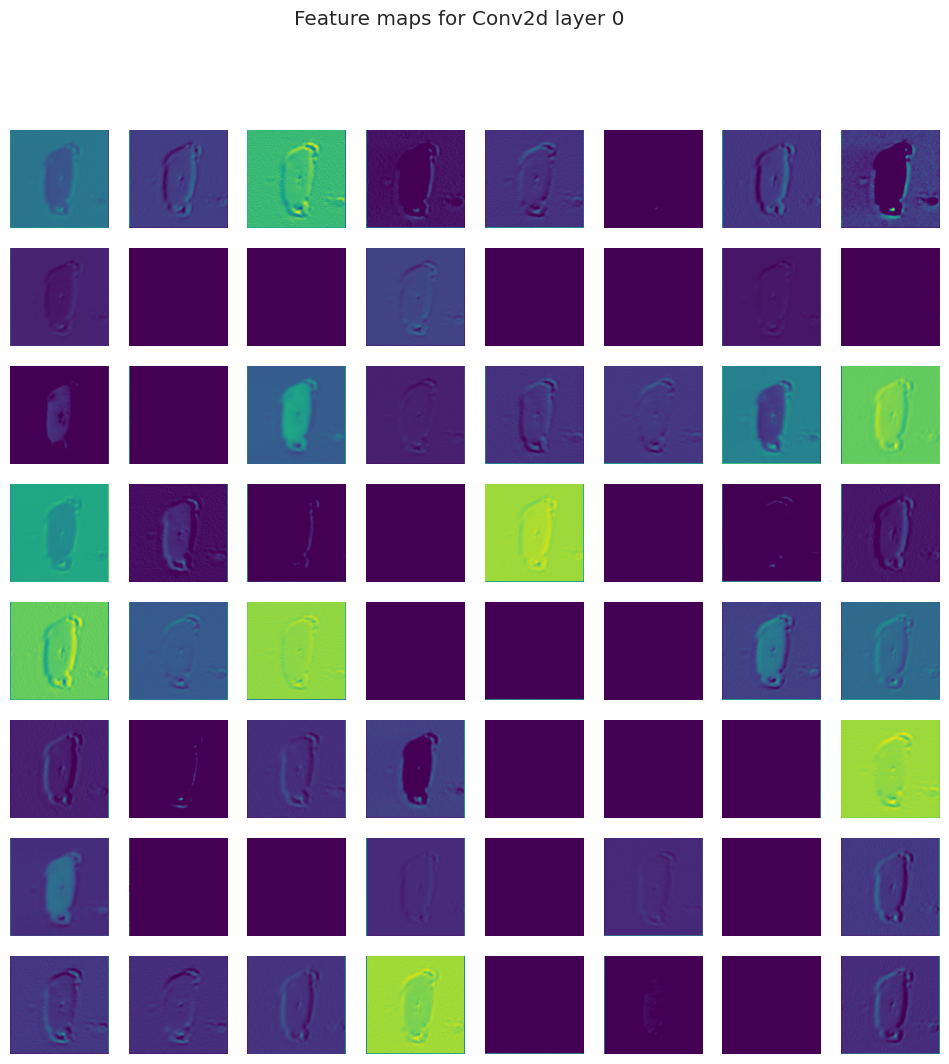

Feature maps for Conv2d layer 0


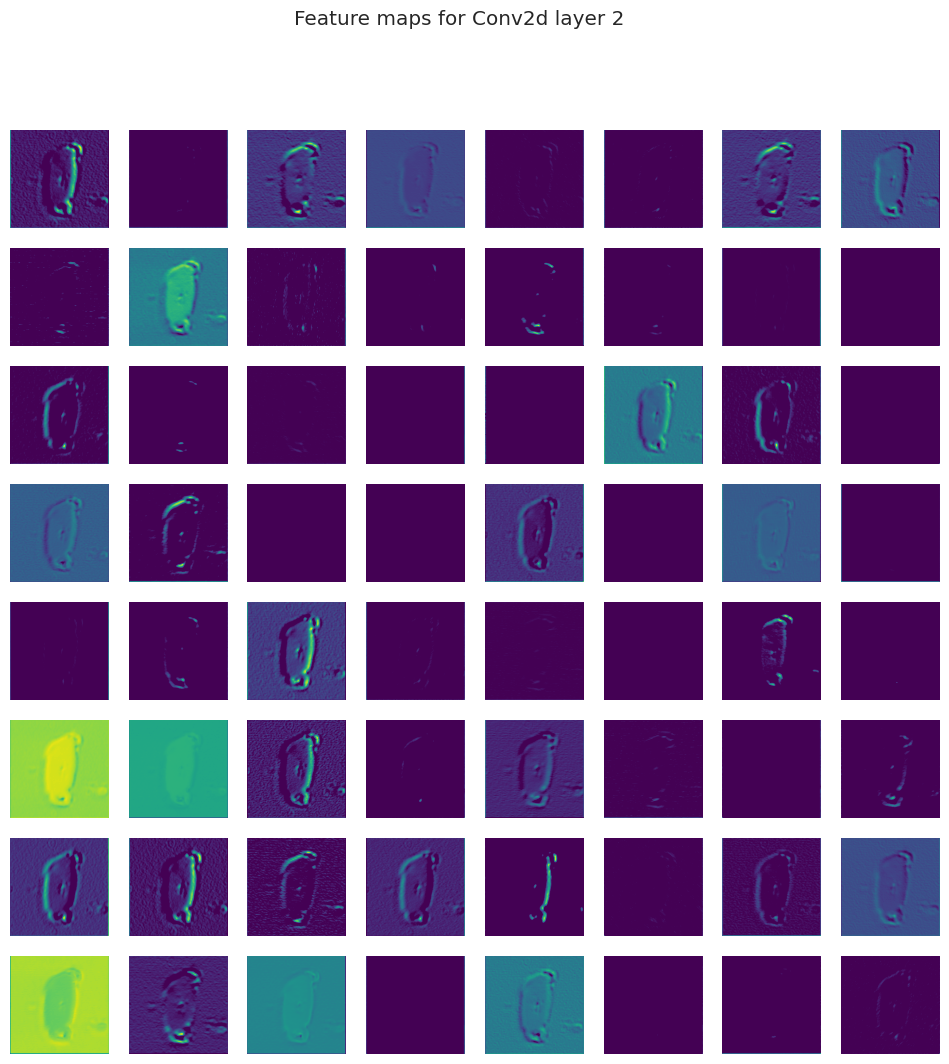

Feature maps for Conv2d layer 2


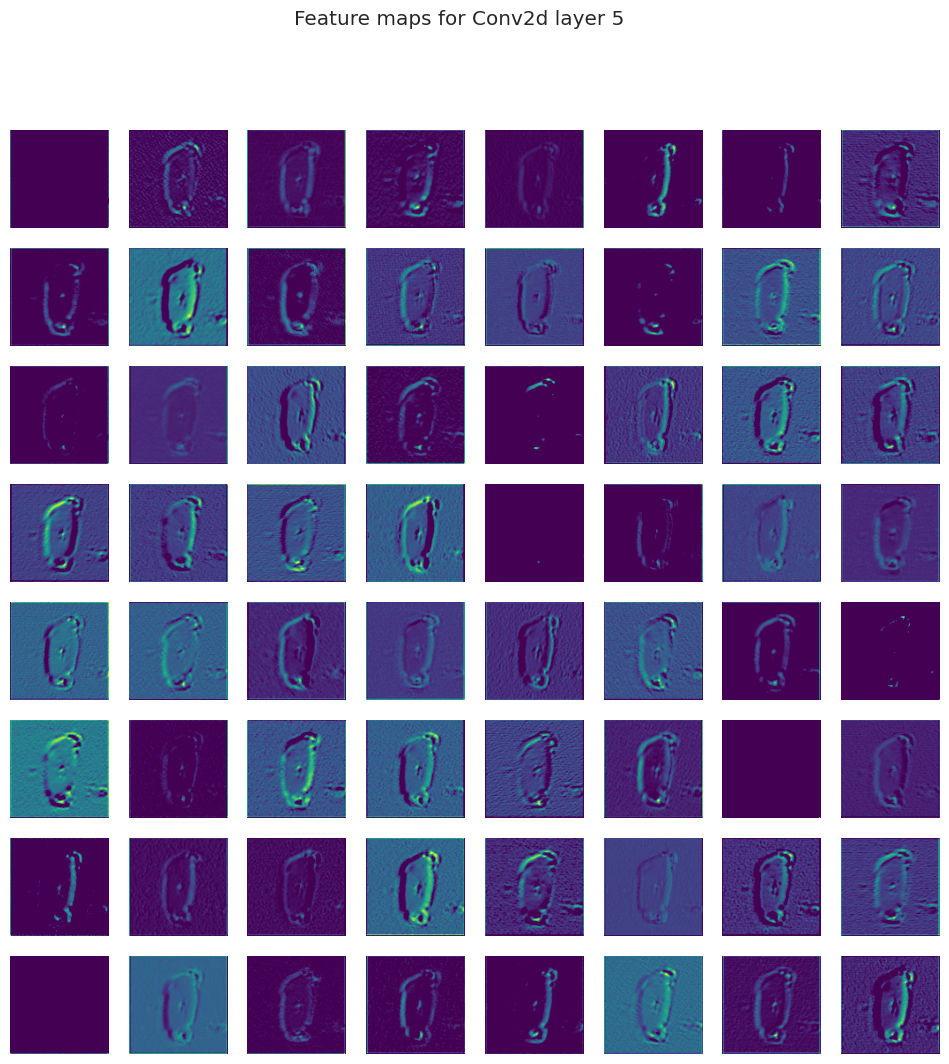

Feature maps for Conv2d layer 5


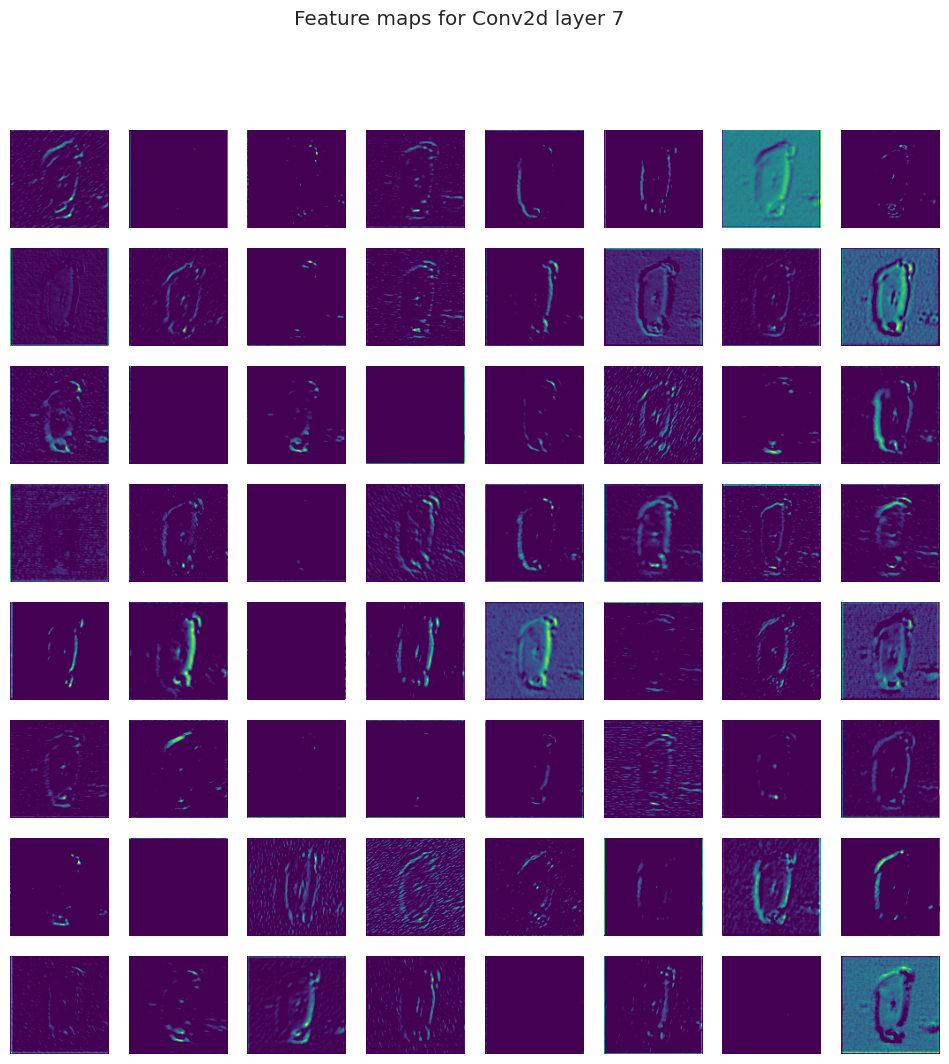

Feature maps for Conv2d layer 7


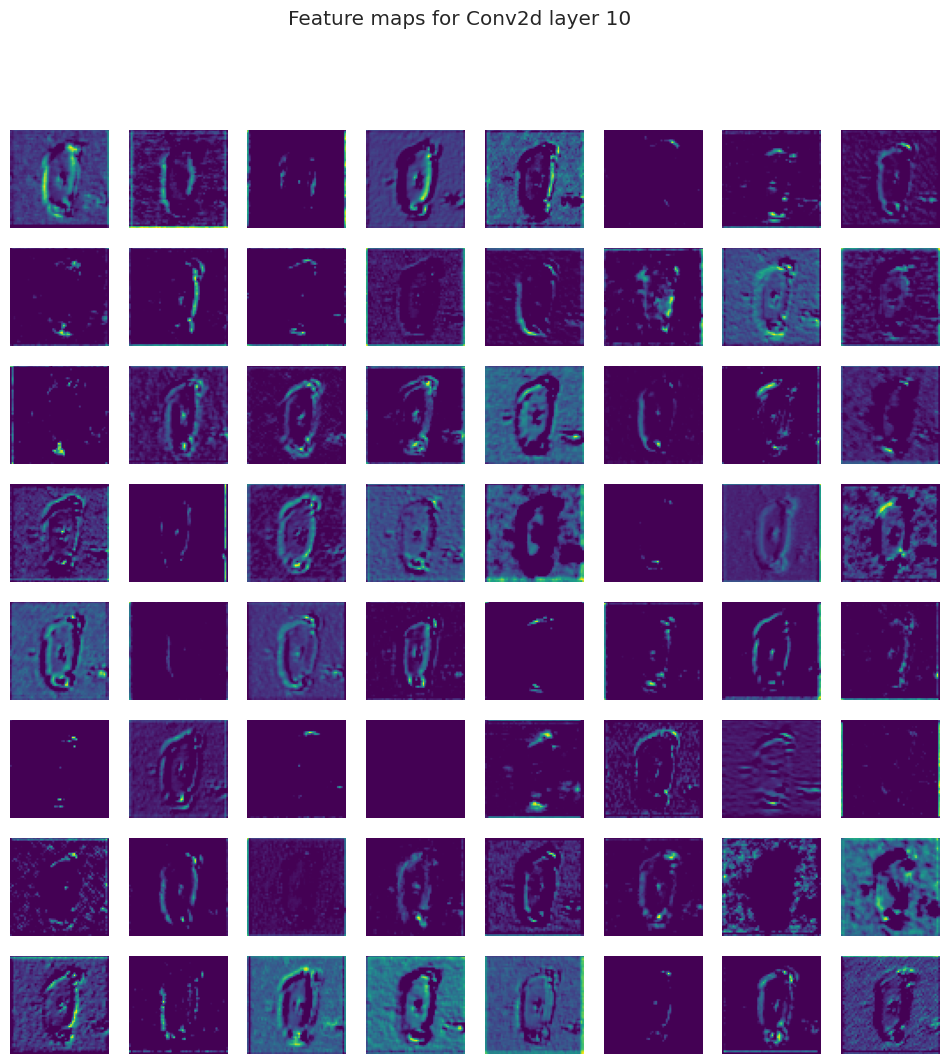

Feature maps for Conv2d layer 10


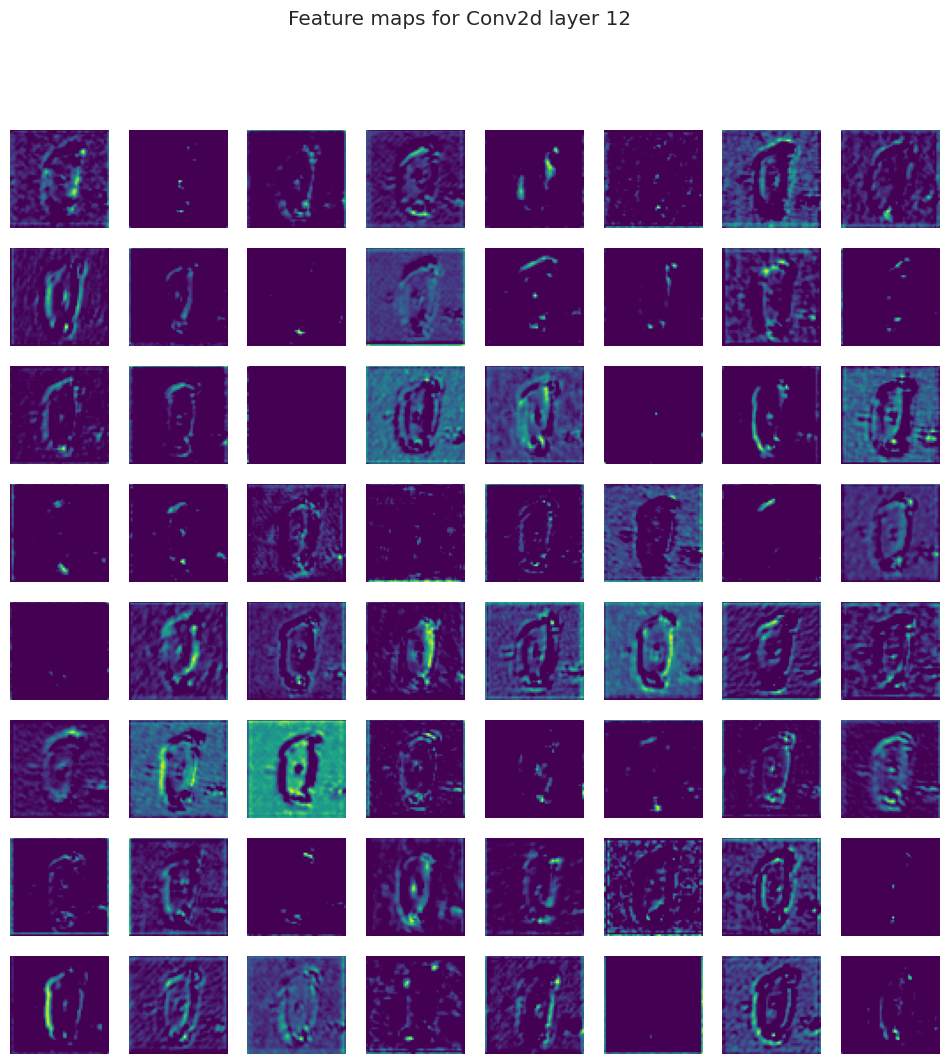

Feature maps for Conv2d layer 12


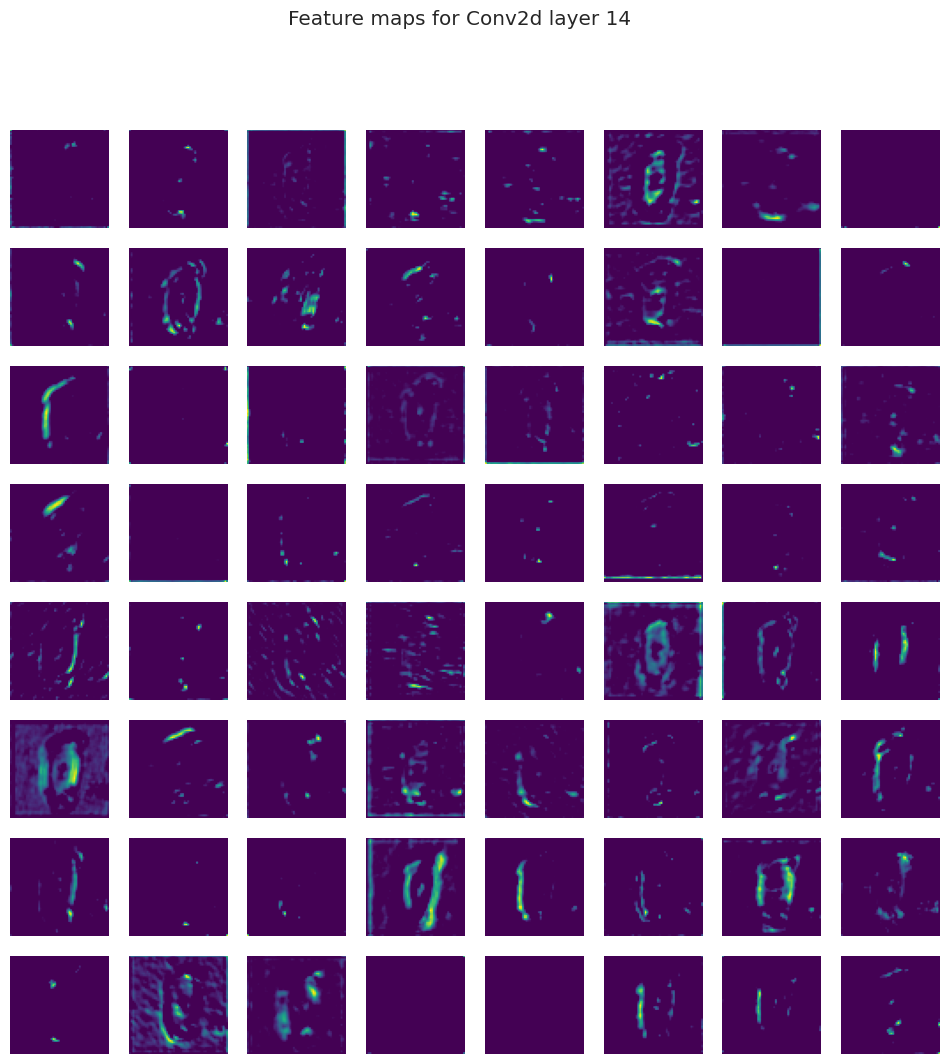

Feature maps for Conv2d layer 14


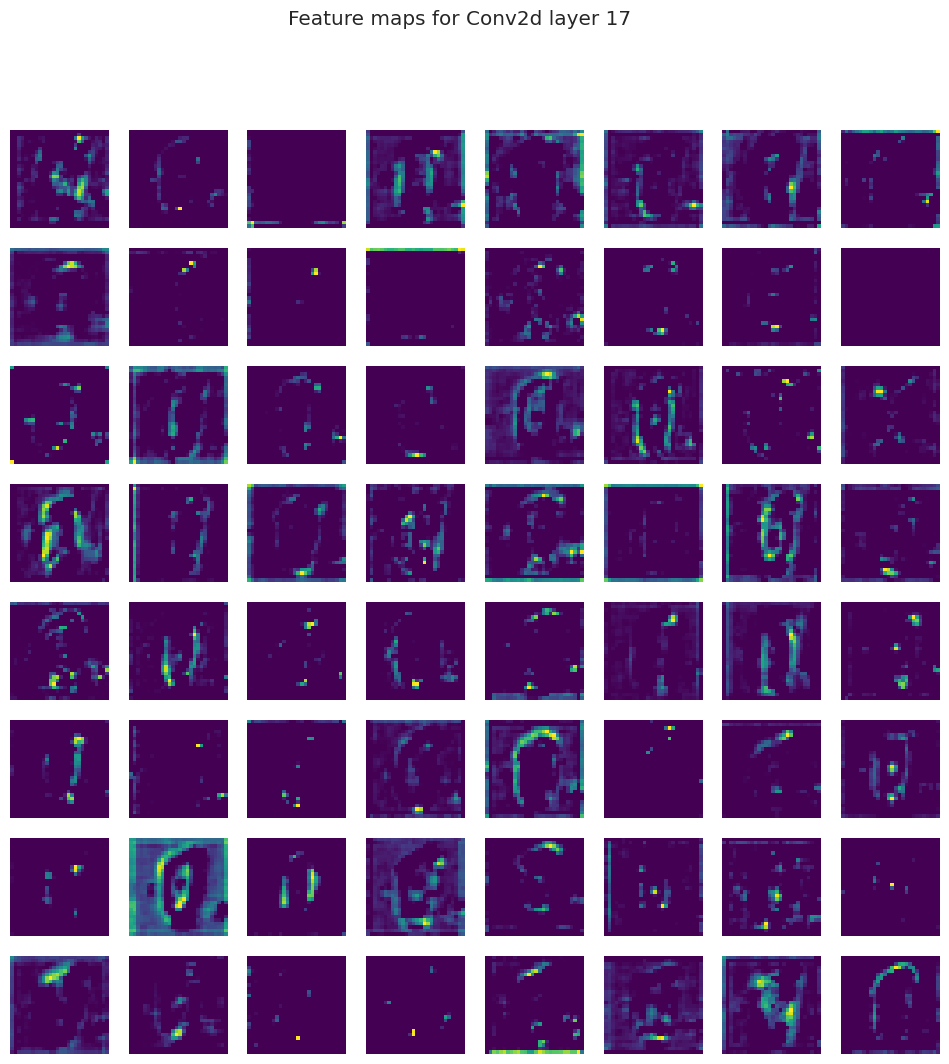

Feature maps for Conv2d layer 17


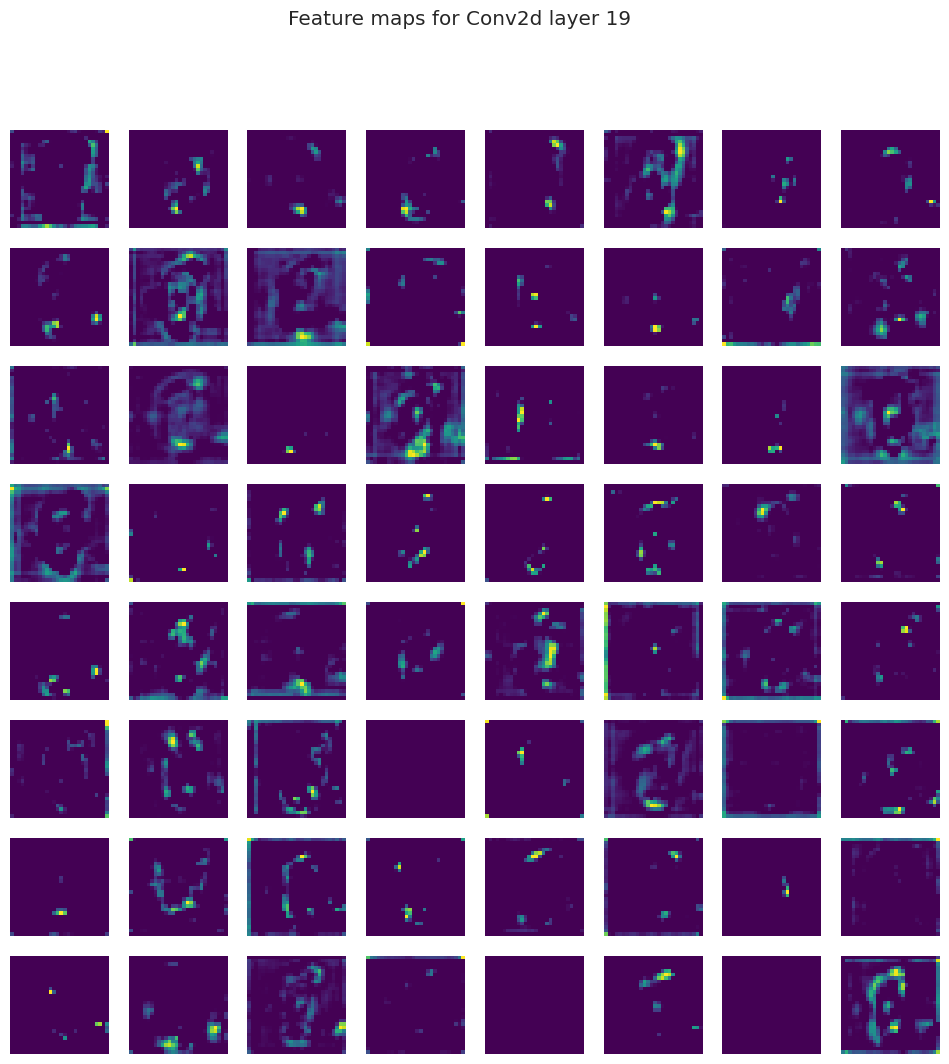

Feature maps for Conv2d layer 19


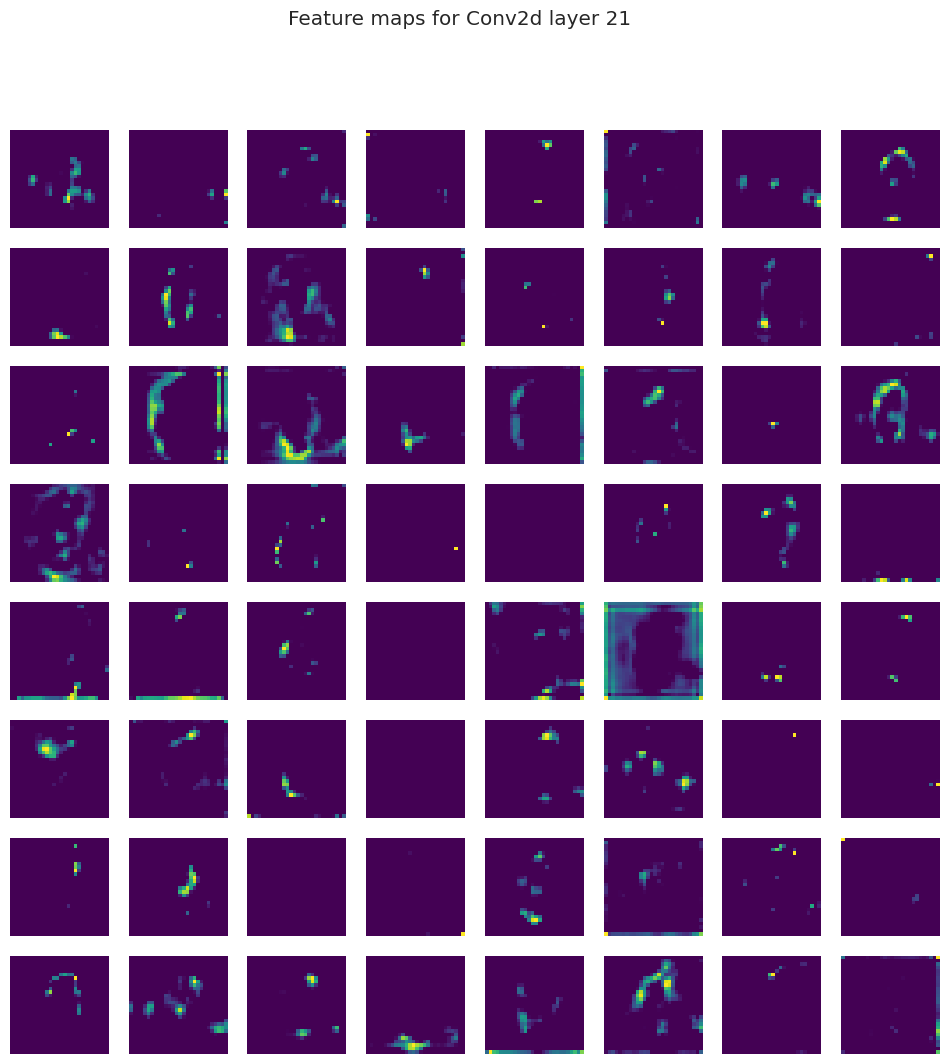

Feature maps for Conv2d layer 21


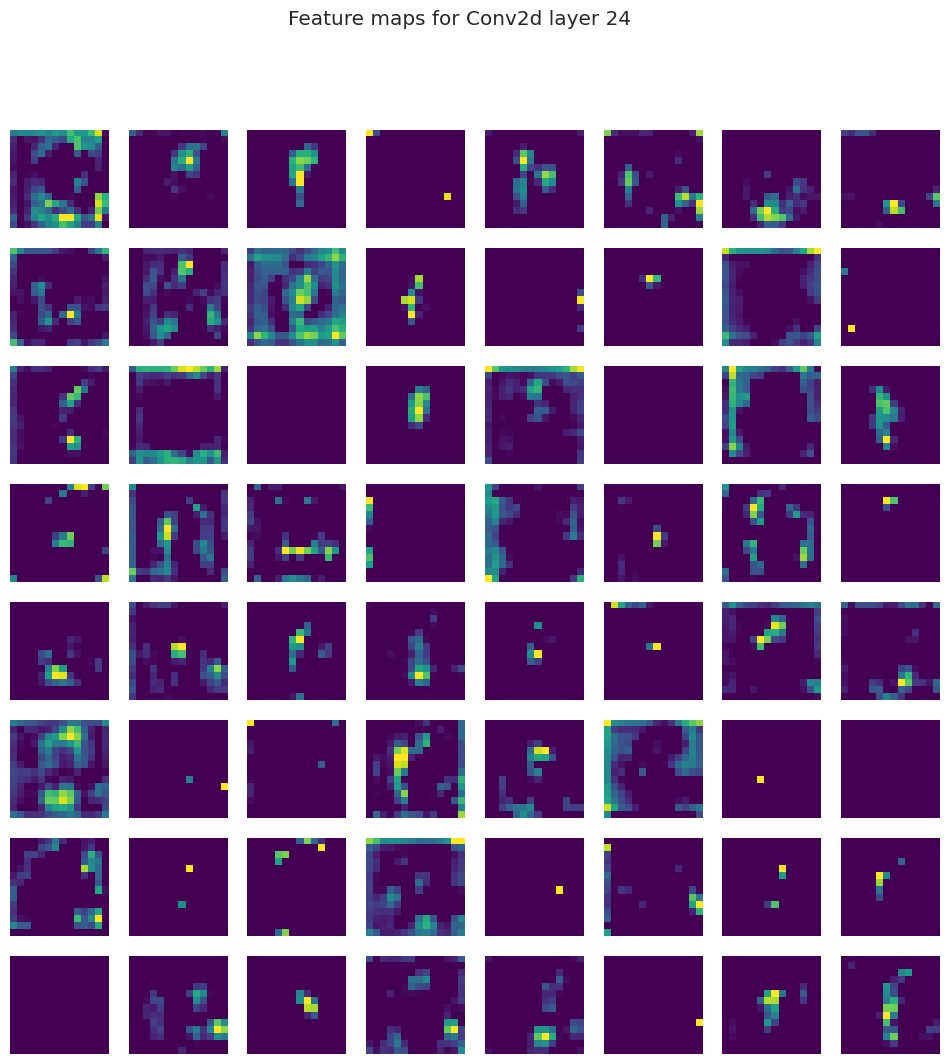

Feature maps for Conv2d layer 24


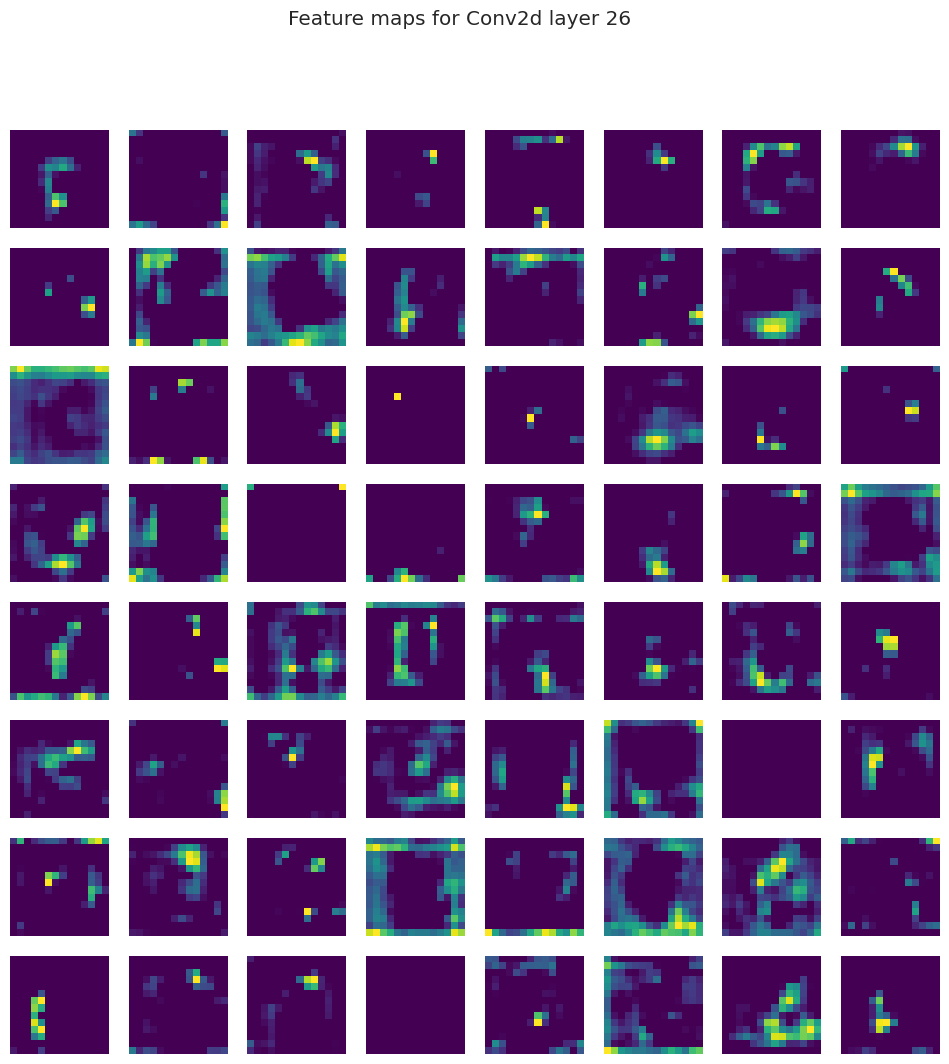

Feature maps for Conv2d layer 26


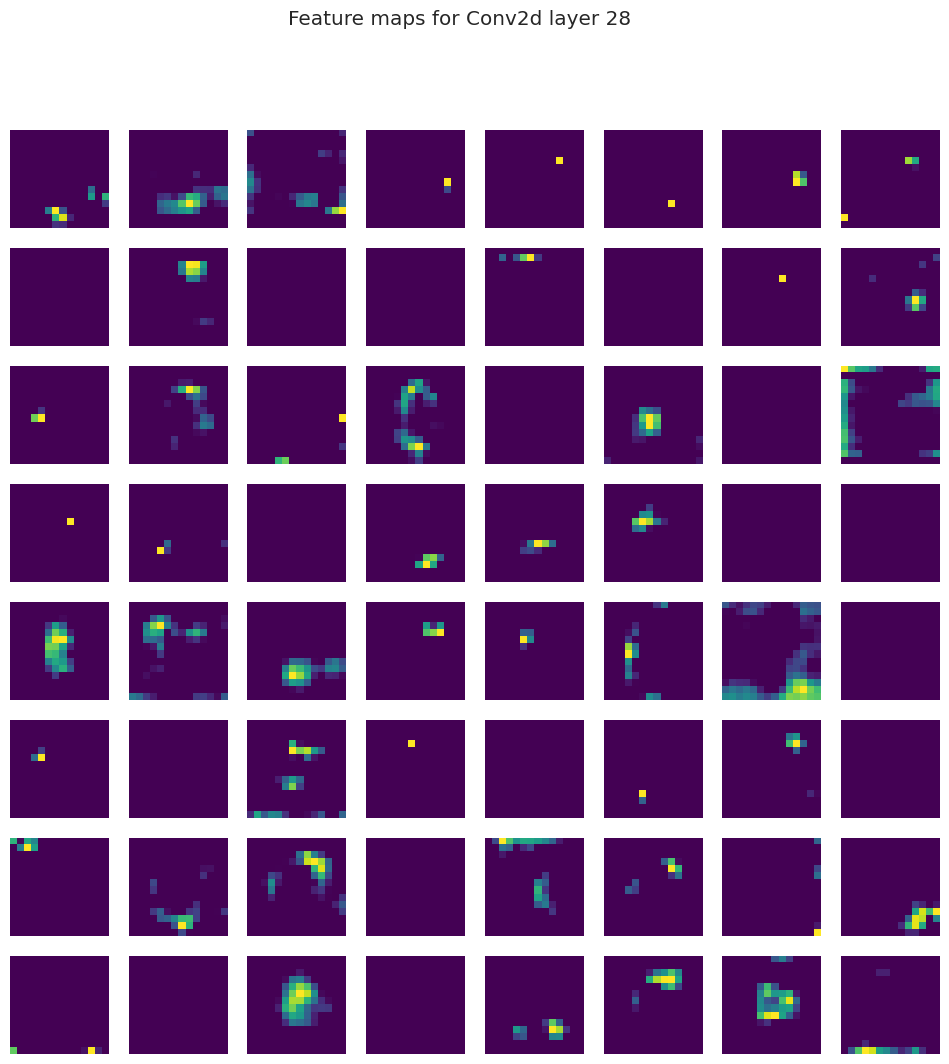

Feature maps for Conv2d layer 28


In [35]:
# Function to attach a hook to the layers
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

# Iterate through each layer in the features module of the VGG model
for layer_num, layer in enumerate(model.features):
    if isinstance(layer, torch.nn.modules.conv.Conv2d):
        # Register hook to the Conv2d layer
        layer.register_forward_hook(get_activation(f'conv{layer_num}'))

# Forward pass
image = misclassified_images[0].unsqueeze(0).to(device)  # Adding batch dimension and sending to device
_ = model(image)

# Plot the feature maps
for layer_num, layer in enumerate(model.features):
    if isinstance(layer, torch.nn.modules.conv.Conv2d):
        # Access the feature maps
        feature_maps = activation[f'conv{layer_num}']
        
        # Convert to a grid of images and move channels to the end for plotting
        grid = feature_maps[0].cpu().moveaxis(0, -1)  # Assuming the first image in the batch
        
        # Number of feature maps to plot (up to a maximum of 64 for visualization purposes)
        num_feature_maps = min(grid.shape[2], 64)
        
        # Create a subplot for each feature map
        fig, axes = plt.subplots(8, 8, figsize=(12, 12))  # Adjust subplot size if needed
        fig.suptitle(f'Feature maps for Conv2d layer {layer_num}')
        for i in range(num_feature_maps):
            ax = axes[i // 8, i % 8]
            ax.imshow(grid[:, :, i], cmap='viridis')
            ax.axis('off')
        plt.show()
        print(f'Feature maps for Conv2d layer {layer_num}')